---

# KDDCUP99_Rev

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import nn

from time import time
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, average_precision_score,auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import shuffle

import pandas as pd
import os
import sys

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

os.environ['CUDA_VISIBLE_DEVICES'] = '3'

device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')

from load_data import get_KDDCUP99_REV
from FGAN_MODEL import FenceGAN

In [2]:
def meanAUC_PRAUC(auc_list, pr_list, name, SPACE_AUC, SPACE_AUPRC):
    print('AUC:')
    print(auc_list)
    print('**************')
    print('PR AUC:')
    print(pr_list)
    print('**************')
    
    
    AUC_Frame = pd.DataFrame(auc_list, columns = [name])
    PR_AUC_Frame = pd.DataFrame(pr_list, columns = [name])
    
    AU_NAME = f'{name}.csv'
    
    AUC_Frame.to_csv(os.path.join(SPACE_AUC, AU_NAME), index=False)
    PR_AUC_Frame.to_csv(os.path.join(SPACE_AUPRC, AU_NAME), index=False)
    
    AUC_Frame = list(AUC_Frame[name])

    N = len(AUC_Frame)
    mean_auc = np.mean(AUC_Frame)
    std_auc = np.std(AUC_Frame)
    std_error = std_auc / (np.sqrt(N))

    ci = 1.96 * std_error
    lower_bound = mean_auc - ci
    upper_bound = mean_auc + ci
    
    print('AUC')
    print(f'{mean_auc:.2f} +/- {ci:.2f}')
    print(f'95% confidence level, average auc would be between {lower_bound:.2f} and {upper_bound:.2f}')
    print('**************')
    
    PR_AUC_Frame = list(PR_AUC_Frame[name])

    N = len(PR_AUC_Frame)
    mean_auc = np.mean(PR_AUC_Frame)
    std_auc = np.std(PR_AUC_Frame)
    std_error = std_auc / (np.sqrt(N))

    ci = 1.96 * std_error
    lower_bound = mean_auc - ci
    upper_bound = mean_auc + ci
    
    print('PR AUC')
    print(f'{mean_auc:.2f} +/- {ci:.2f}')
    print(f'95% confidence level, average auc would be between {lower_bound:.2f} and {upper_bound:.2f}')

In [3]:
batch_size = 1024

WORK_SPACE = '../Dataset'
FILE = 'kddcup.data_10_percent_corrected'

SPACE_MODELS = './models'
SPACE_AUC = './auc'
SPACE_AUPRC = './auprc'

for n in (SPACE_MODELS, SPACE_AUC, SPACE_AUPRC):
    if not os.path.exists(n):
        os.mkdir(n)
        
DATASET = 'KDDCUP99_REV'

PATH = os.path.join(WORK_SPACE, FILE)

In [4]:
dataset = get_KDDCUP99_REV(PATH, seed, show=True)

97278 normal records, 8752 anormal records
We use 4376 anomalous records
-----------------------------------------------------------------------------------------
There are 81323 records in training set
Training set is composed by 81323 normal records and 0 abnormal records
-----------------------------------------------------------------------------------------
There are 5083 records in validation set
Validation set is composed by 3989 normal records and 1094 abnormal records
-----------------------------------------------------------------------------------------
There are 15248 records in test set
Test set is composed by 11966 normal records and 3282 abnormal records


In [5]:
nc = dataset['x_train'].shape[1]
z_dim = 32
gamma = 0.1
alpha = 0.5 
beta = 30 
_power = 2
v_freq = 4

g_objective_anneal = 1
repeat = 4 
baseline = 0.5

#### Mean AUC and standard deviation after seven runs

Iteration: 1
Epoch #1: Loss: 0.8007
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.095 | g_loss: 2.8961
[INFO] Training phase... Elapsed time: 451 seconds



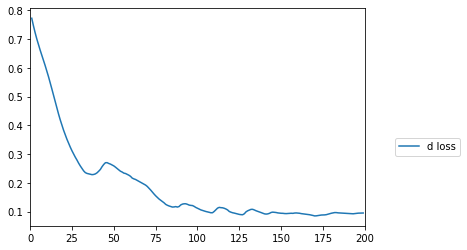

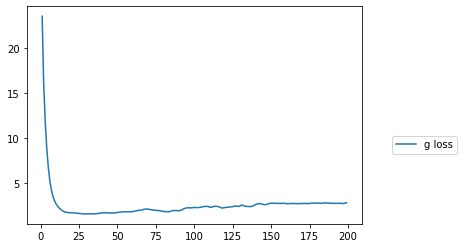

PR AUC: 0.75


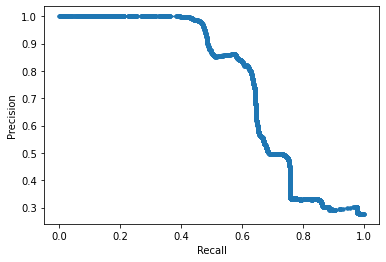

AUC: 0.84
Iteration: 2
Epoch #1: Loss: 0.7930
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.097 | g_loss: 2.8489
[INFO] Training phase... Elapsed time: 499 seconds



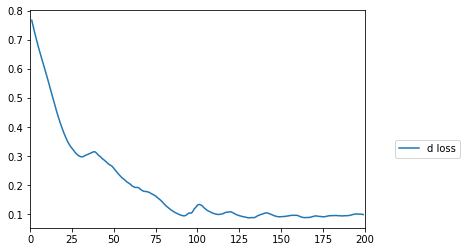

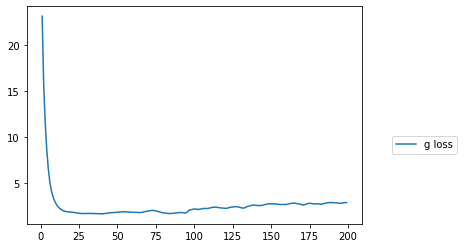

PR AUC: 0.77


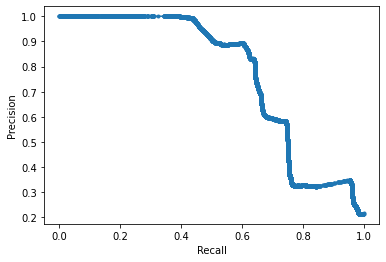

AUC: 0.85
Iteration: 3
Epoch #1: Loss: 0.7991
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.100 | g_loss: 2.8381
[INFO] Training phase... Elapsed time: 554 seconds



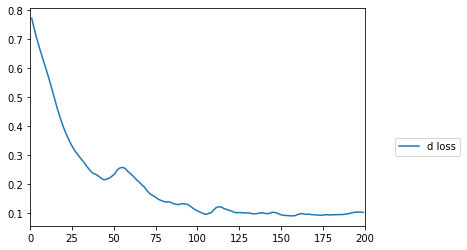

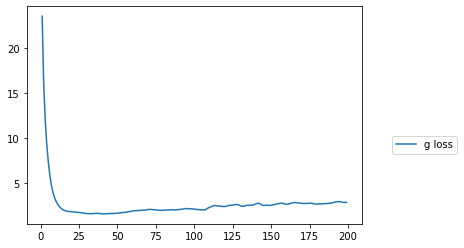

PR AUC: 0.76


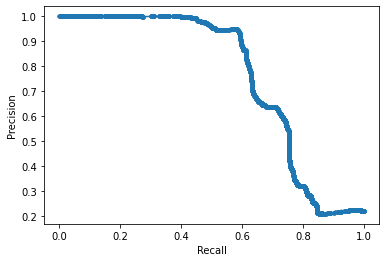

AUC: 0.80
Iteration: 4
Epoch #1: Loss: 0.7087
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.102 | g_loss: 2.8138
[INFO] Training phase... Elapsed time: 550 seconds



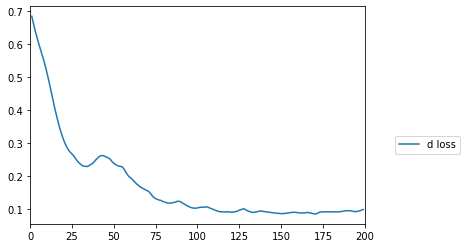

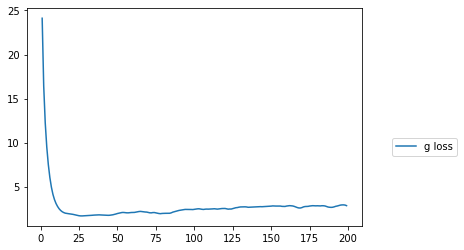

PR AUC: 0.78


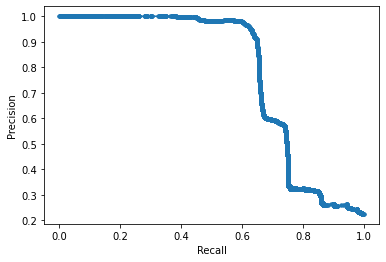

AUC: 0.83
Iteration: 5
Epoch #1: Loss: 0.7612
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.104 | g_loss: 2.9225
[INFO] Training phase... Elapsed time: 558 seconds



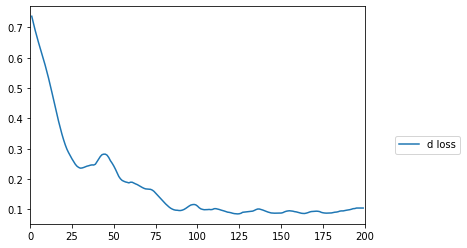

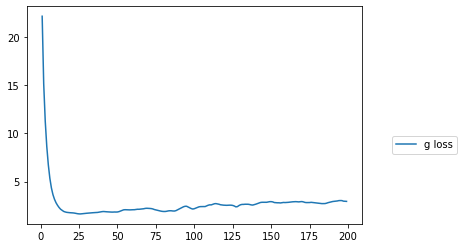

PR AUC: 0.75


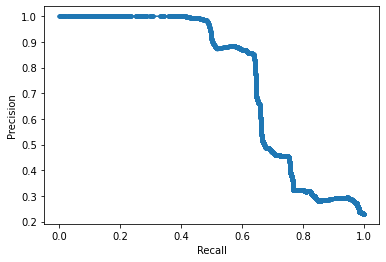

AUC: 0.83
Iteration: 6
Epoch #1: Loss: 0.7609
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.097 | g_loss: 2.7885
[INFO] Training phase... Elapsed time: 550 seconds



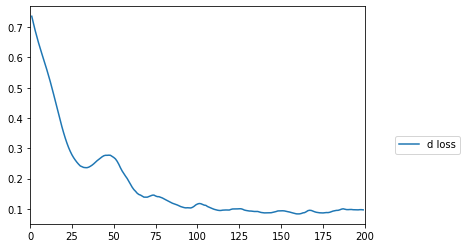

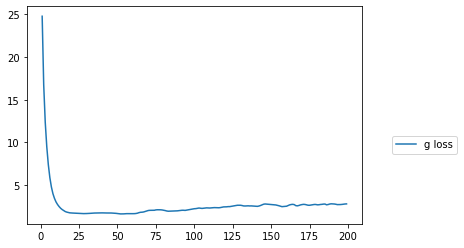

PR AUC: 0.79


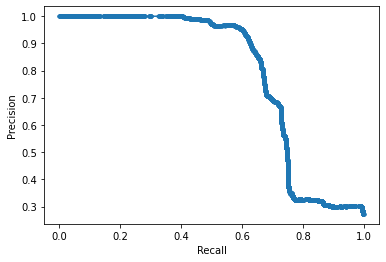

AUC: 0.86
Iteration: 7
Epoch #1: Loss: 0.7534
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.089 | g_loss: 2.6221
[INFO] Training phase... Elapsed time: 554 seconds



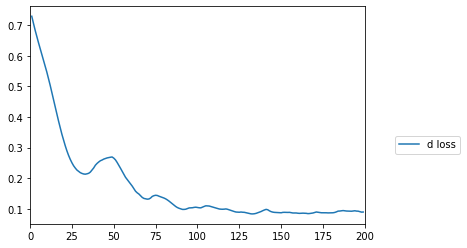

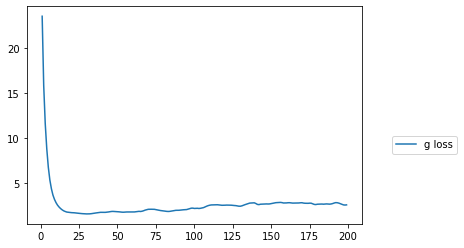

PR AUC: 0.78


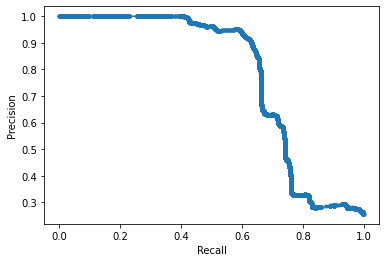

AUC: 0.84
Iteration: 8
Epoch #1: Loss: 0.7889
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.099 | g_loss: 2.9660
[INFO] Training phase... Elapsed time: 546 seconds



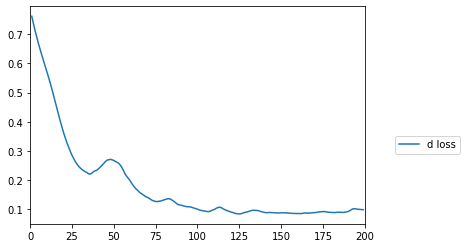

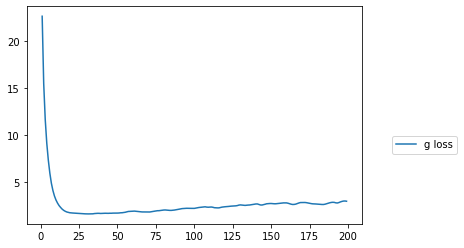

PR AUC: 0.79


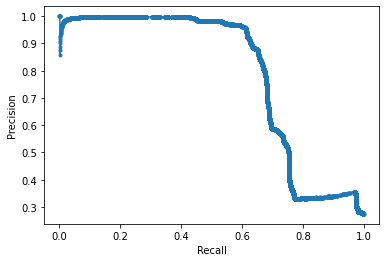

AUC: 0.87
Iteration: 9
Epoch #1: Loss: 0.7879
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.098 | g_loss: 2.8030
[INFO] Training phase... Elapsed time: 543 seconds



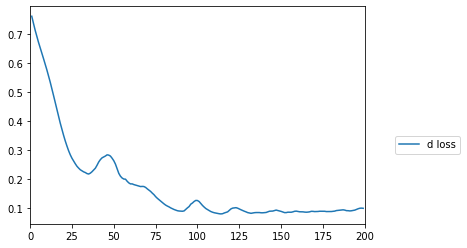

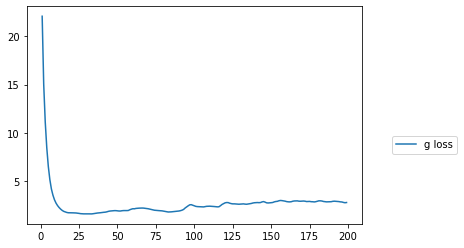

PR AUC: 0.79


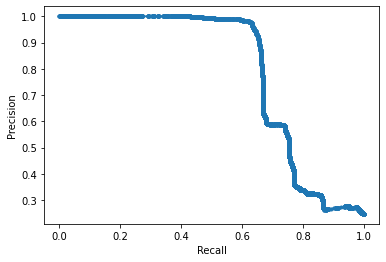

AUC: 0.85
Iteration: 10
Epoch #1: Loss: 0.7366
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.096 | g_loss: 2.9375
[INFO] Training phase... Elapsed time: 545 seconds



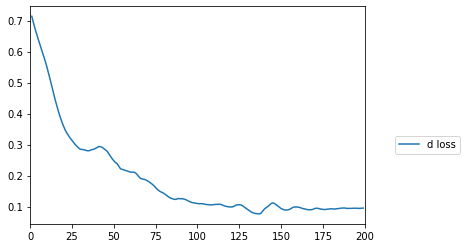

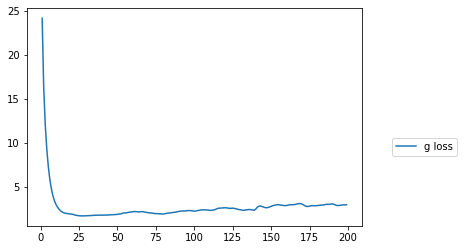

PR AUC: 0.76


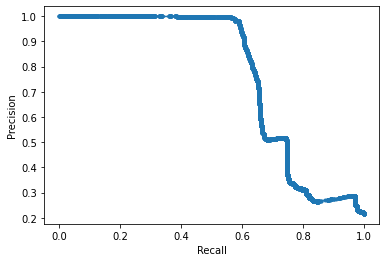

AUC: 0.83
Iteration: 11
Epoch #1: Loss: 0.7308
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.102 | g_loss: 2.7905
[INFO] Training phase... Elapsed time: 546 seconds



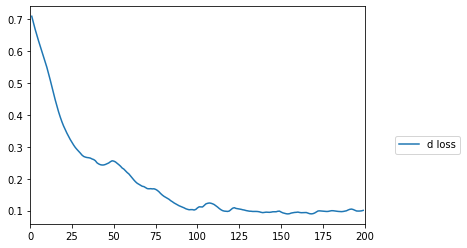

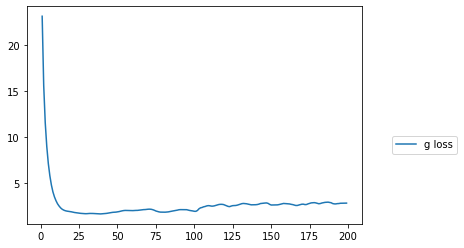

PR AUC: 0.72


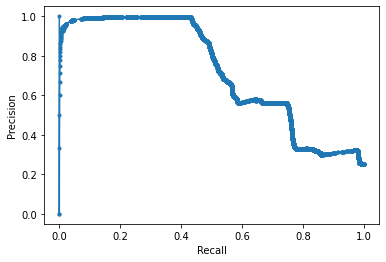

AUC: 0.84
Iteration: 12
Epoch #1: Loss: 0.7538
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.094 | g_loss: 2.8622
[INFO] Training phase... Elapsed time: 556 seconds



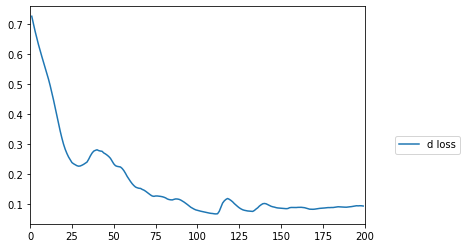

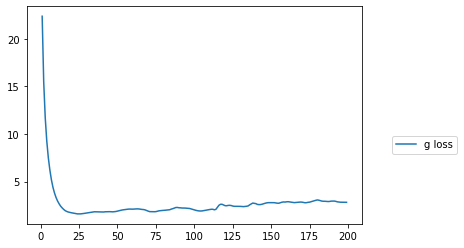

PR AUC: 0.78


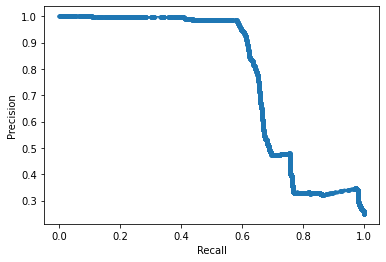

AUC: 0.86
Iteration: 13
Epoch #1: Loss: 0.7333
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.090 | g_loss: 2.8249
[INFO] Training phase... Elapsed time: 563 seconds



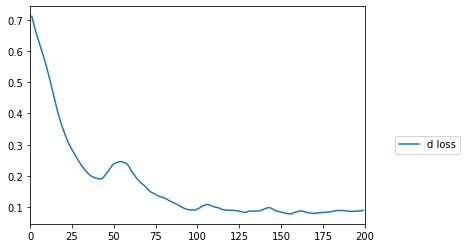

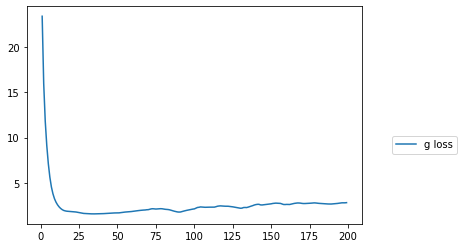

PR AUC: 0.78


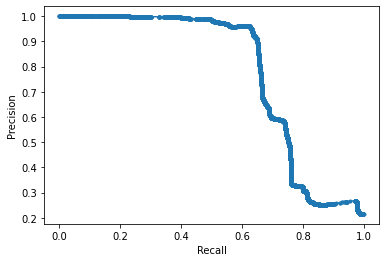

AUC: 0.82
Iteration: 14
Epoch #1: Loss: 0.7298
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.098 | g_loss: 2.9952
[INFO] Training phase... Elapsed time: 561 seconds



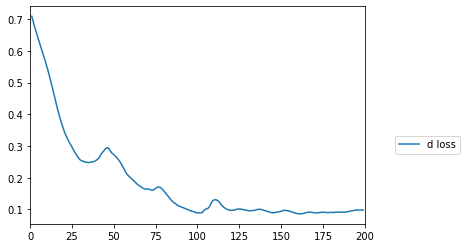

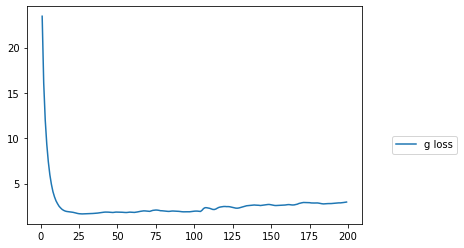

PR AUC: 0.77


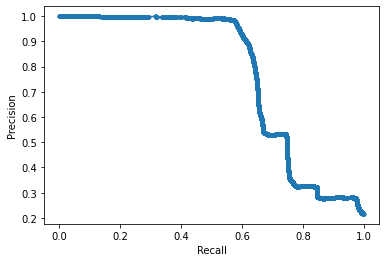

AUC: 0.83
Iteration: 15
Epoch #1: Loss: 0.7780
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.096 | g_loss: 2.8539
[INFO] Training phase... Elapsed time: 562 seconds



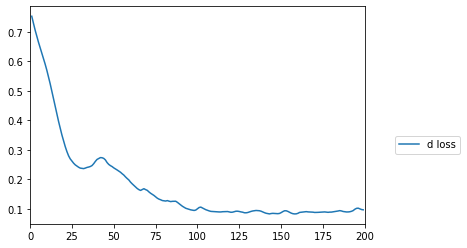

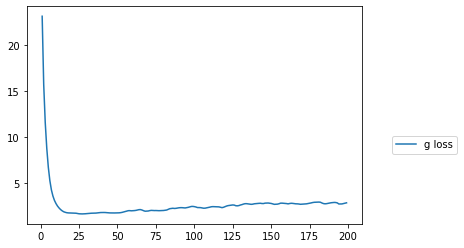

PR AUC: 0.75


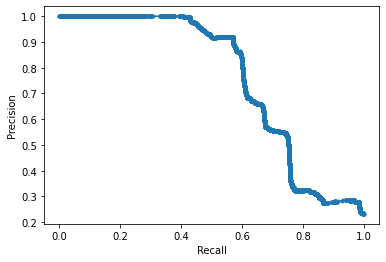

AUC: 0.84
Iteration: 16
Epoch #1: Loss: 0.7673
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.097 | g_loss: 2.8916
[INFO] Training phase... Elapsed time: 548 seconds



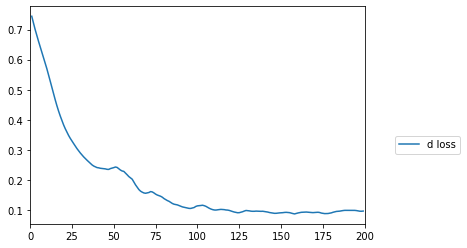

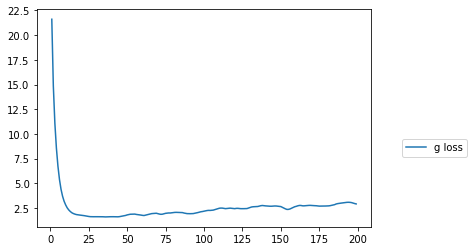

PR AUC: 0.77


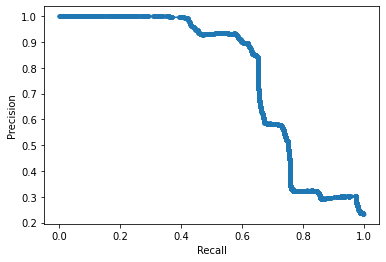

AUC: 0.85
Iteration: 17
Epoch #1: Loss: 0.7908
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.099 | g_loss: 2.9927
[INFO] Training phase... Elapsed time: 529 seconds



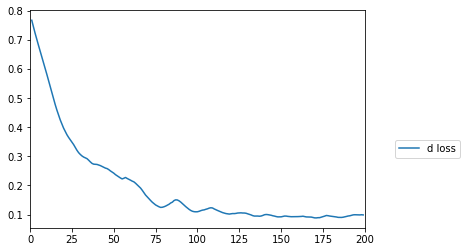

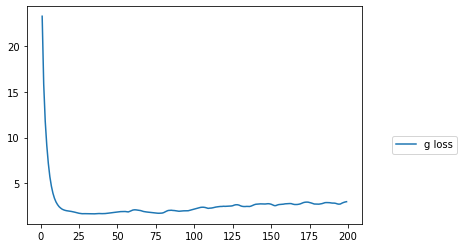

PR AUC: 0.75


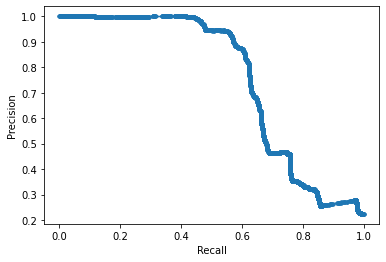

AUC: 0.83
Iteration: 18
Epoch #1: Loss: 0.7598
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.099 | g_loss: 2.7599
[INFO] Training phase... Elapsed time: 528 seconds



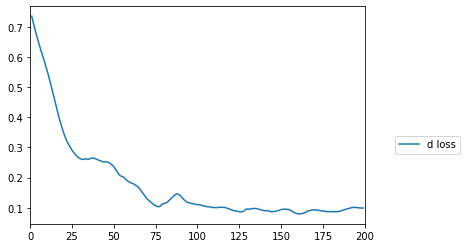

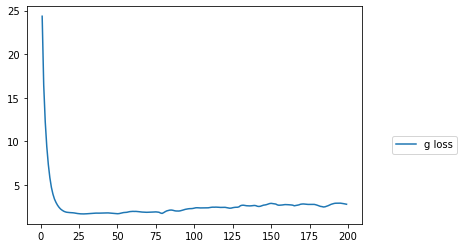

PR AUC: 0.76


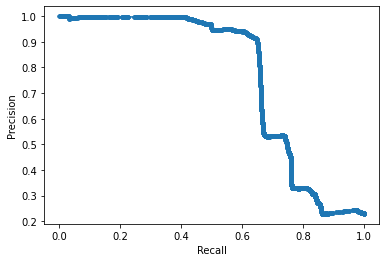

AUC: 0.82
Iteration: 19
Epoch #1: Loss: 0.7717
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.106 | g_loss: 2.7958
[INFO] Training phase... Elapsed time: 499 seconds



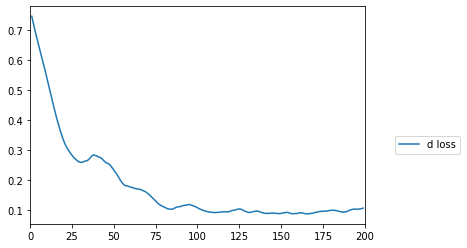

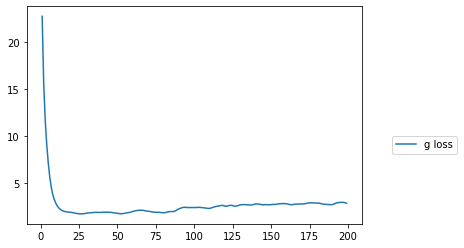

PR AUC: 0.78


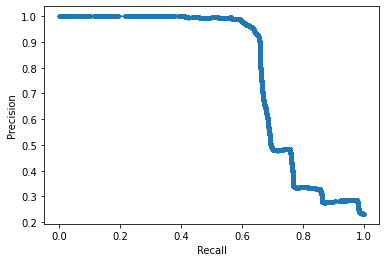

AUC: 0.84
Iteration: 20
Epoch #1: Loss: 0.7300
[INFO] Starting training phase...
Epoch [200/200] | d_loss: 0.092 | g_loss: 2.6595
[INFO] Training phase... Elapsed time: 488 seconds



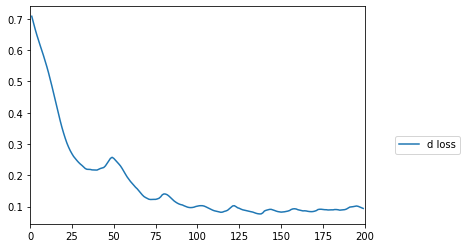

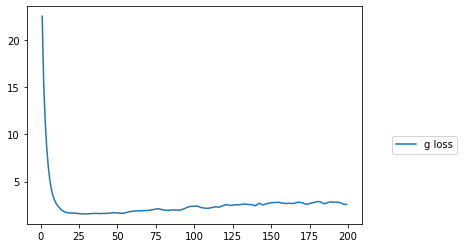

PR AUC: 0.76


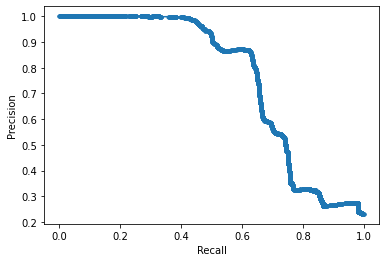

AUC: 0.83


In [6]:
n_runs = 20
auc_list = []
n_epochs = 200
seed = 42
pr_list = []

for i in range(n_runs):
    print(f'Iteration: {i+1}')
    dataset = get_KDDCUP99_REV(PATH, seed*(i+1), show=False)
    
    train_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_train']).to(device), 
                                              torch.tensor(dataset['y_train'].to_numpy()).to(device))
    
    train_loader = DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle=True, drop_last = True)

    val_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_val']).to(device), 
                                              torch.tensor(dataset['y_val'].to_numpy()).to(device))
    val_loader = DataLoader(dataset=val_dataset, batch_size = batch_size, shuffle=False)

    test_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_test']).to(device), 
                                              torch.tensor(dataset['y_test'].to_numpy()).to(device))
    test_loader = DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle=False)
    
    trainer = FenceGAN(nc, z_dim, gamma, alpha, beta, _power, v_freq, g_objective_anneal, repeat, baseline, device)
    
    d_losses, g_losses = trainer.train(train_loader, test_loader, val_loader, batch_size, n_epochs)
    
    # Save models
    NAME_D = f'D_FGAN_{DATASET}_{i}.ckpt'
    NAME_G = f'G_FGAN_{DATASET}_{i}.ckpt'
    
    torch.save(trainer.D.state_dict(), os.path.join(SPACE_MODELS, NAME_D))
    torch.save(trainer.G.state_dict(), os.path.join(SPACE_MODELS, NAME_G))
    
    _auc, pr_auc = trainer.predict(test_loader)
    print(f'AUC: {_auc:.2f}')
    auc_list.append(_auc)
    pr_list.append(pr_auc)

In [7]:
meanAUC_PRAUC(auc_list, pr_list, 'FGAN_LR_KDDCUP99_REV', SPACE_AUC, SPACE_AUPRC)

AUC:
[0.8428000678949894, 0.8501834442967242, 0.7986960031892107, 0.8292558781467254, 0.8318908194383374, 0.857222253117532, 0.8429507207247673, 0.86820498827523, 0.8458564882645863, 0.8255857827117927, 0.8410160038044009, 0.8587136180991379, 0.8238211724810791, 0.8346504793237552, 0.8360785937976003, 0.8454715488317854, 0.8253500065134782, 0.8162027455813001, 0.8443709925430605, 0.8325018972606011]
**************
PR AUC:
[0.7513633335577651, 0.7683648310015377, 0.7590929633893556, 0.7770143915821128, 0.7534999576530884, 0.7887726893280517, 0.7757999046642667, 0.7908232636556223, 0.7883900333260964, 0.7648688606733371, 0.721414313707017, 0.7764252049491782, 0.7759939164466205, 0.7685106337761959, 0.754812181759467, 0.7689250362676687, 0.7521844405012191, 0.7647382254583206, 0.782603160518118, 0.758144371049817]
**************
AUC
0.84 +/- 0.01
95% confidence level, average auc would be between 0.83 and 0.84
**************
PR AUC
0.77 +/- 0.01
95% confidence level, average auc would be 

---